# Estimating Epidemic models from observations

**Background**:
An important part of mathematical modeling is fitting models to observed data that is collected from a surveillance system.
Models can serve as tools to understand the mechanics of how a pathogen moves through one or more populations, used to produce forward-looking predictions about what may happen, or studied under different interventions to evaluate their potential usefulness.

We will take the following steps to understand how to fit a compartmental model to data 
1. Build a simulation that generates data from a SIR model. To understand how to fit a model we must first understand how a model could potentially generate our dataset.
2. Briefly remember how a linear regression model, $y \sim \mathcal{N}(\mu(x), \sigma^{2})$, is fit to data.
3. Apply the "sum squares error" approach in (2) to our compartmental model.
4. Generalize (2) and (3) to other data generating mechanisms with maximum likelihood estimation.   

Compartmental models can be thought of as functions from time and a set of parameters to a set of states over time or $f(t_{0},t_{1},t_{2}\cdots,t_{T}; \theta)$. 
For example, we can think of the SIR model as a function that takes as input times $t = [t_{0},t_{1},t_{2}, \cdots, t_{T}]$, two parameter values $\theta = (\beta, \gamma)$ and then outputs the proportion of susceptibles, infected, removed over time. 

\begin{align}
    t &= (t_{0}, t_{1}, \cdots, t_{T})\\
    \theta &= (3/2, 1/2)\\
    M &= \textrm{SIR}( t; \theta )
\end{align}

where $M$ is the matrix 

\begin{align}
    M = \begin{bmatrix}
    S_{0} & S_{1} & S_{2} & \cdots & S_{T} \\   
    I_{0} & I_{1} & I_{2} & \cdots & I_{T} \\
    R_{0} & R_{1} & R_{2} & \cdots & R_{T} \\
    i_{0} & i_{1} & i_{2} & \cdots & i_{T} \\
    \end{bmatrix}
\end{align}

Lets assume that we collect the number of incident infected cases over the times $t = [0,1,2,3,4,5,\cdots,10]$ and plot this as black circles (below). 

## Simulating data from a SIR model---Data Generating Process

Assume that the pathogen under study follows SIR dynamics. 

\begin{align}
    \dot{S} =  \frac{dS}{dt} &= -\beta S \frac{I}{N} \\ 
    \dot{I}  &=  \beta S \frac{I}{N} - \gamma I \\ 
    \dot{R}  &=  \gamma I \\ 
\end{align}

Then given a vector of parameters $\theta = (\beta, \gamma)$ and a tuple of initial condition we can estimate solutions $S(t),I(t),R(t)$.


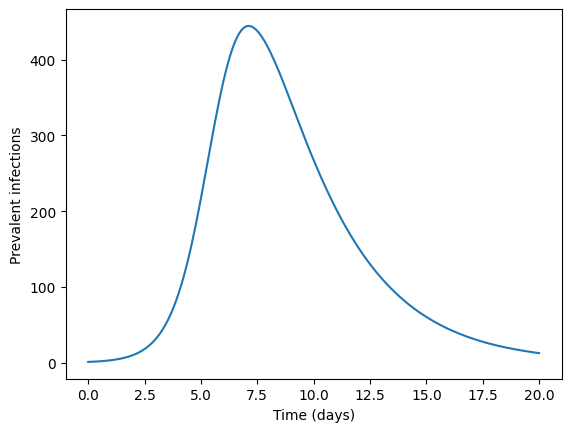

In [9]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.integrate import solve_ivp

n = 1000 #--number of animals in system 

#--SIR differential equations
def sir(t,y, beta, gamma,n):
    s,i, r, c = y
    ds_dt = -beta*s*i/n
    di_dt = beta*s*i/n - gamma*i
    dr_dt = gamma*i
    
    dc_dt = beta*s*i/n            #--incident cases (why?)
    return [ds_dt, di_dt, dr_dt, dc_dt]

#--start and end times 
start,end = 0., 20

#--times that we want to return s(t), i(t), r(t)
tvals = np.arange(start,end+0.1,0.1)

#--inital conditions for s, i, r
initial_conditions = (999, 1, 0., 0)

#--parameters for the model 
beta, gamma = 3./2, 1./3

#--function to return s,i,r over time
solution = solve_ivp( fun = sir
                     , t_span = (start,end)
                     , y0     = initial_conditions
                     , t_eval = tvals
                     , args   = (beta, gamma,n))
prevalent_infections = solution.y[1,:]
times                = solution.t 

plt.plot(times,prevalent_infections)
plt.xlabel("Time (days)")
plt.ylabel("Prevalent infections")
plt.show()

To generate data from this curve, we need to assume a data generating process.
A data-generating process is a proposed algorithm for how a dataset,$\mathcal{D}$, may have been observed.
A common DGP for prevalent infections from the SIR model is to assume each data point $y_{t}$ was produced by a corresponding random variable $( y_{1} \sim Y_{1},y_{2} \sim Y_{2},y_{3} \sim Y_{3},\cdots,y_{T} \sim Y_{T})$

For the below example, we assume that $Y_{t}$ is a Poisson random variable, i.e. $Y_{t} \sim \text{Poisson}( \lambda(t) )$ where the parameter value $\lambda(t) = I(t)$. To implement this DGP, for $t$ from 0,1,2,3,... to 20 we compute I(t) as we did in the above cell and then draw a value $y_{t}$ from a Poisson distribution where $\lambda$ equals the number of prevalent infections $I(t)$.  

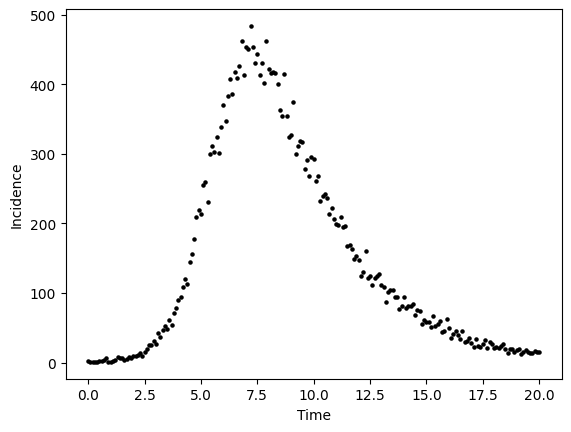

In [10]:
#--add poisson noise
noisy_prevalent_infections = np.random.poisson(prevalent_infections)

fig,ax = plt.subplots()
ax.scatter(times, noisy_prevalent_infections, s=5,color="black")

ax.set_xlabel("Time")
ax.set_ylabel("Incidence")

plt.show()

### Recap 

If we assume that this data is expected to follow SIR dynamics then we suppose two items: (i) that there exists a true SIR model and single set of parameter values $\theta$ that are used to generate the underlying true, never observed, number of prevalent cases and (ii) that there exists a sequence of random variables that use the output from our SIR model to generate the observed number of infections over time. 

We supposed above that the data above is generated by a sequence of Poisson random variables that depend on the number of incident cases at time 1, time 2, time 3, and so on

\begin{align}
    \mathcal{D} = (y_{1}, y_{2}, \cdots, y_{T})\\ 
    y_{1} \sim Y_{1}; \; y_{2} \sim Y_{2}; \; \cdots \; ; y_{T} \sim Y_{T};\\  
    Y_{1} \sim \textrm{Pois}(I_{1}) , Y_{2} \sim \textrm{Pois}(I_{2}), \cdots, Y_{t} \sim \textrm{Pois}(I_{t})\\
    I_{t} = \textrm{SIR}(t;\theta)
\end{align}

This means that different parameter values will lead to different underlying incident cases that may have generated our data.

## Fitting a linear regression model to data 

Suppose the following data generating process

\begin{align}
    \mathcal{D} &= (  (x_{1},y_{1}), (x_{2},y_{2}), (x_{3},y_{3}), \cdots, (x_{T},y_{T}))\\ 
    y_{t}  &\sim \mathcal{N}( \mu(t), \sigma^{2} ) \\
    \mu(t) &= \beta_{0} + \beta_{1}x_{t} \\ 
\end{align}

Lets use this DGP to generate a dataset. Then we will review linear regression fitting. 

          x         y
0 -4.000000 -8.225185
1 -3.919192 -3.493441
2 -3.838384 -9.560624
3 -3.757576 -8.844165
4 -3.676768 -4.940258


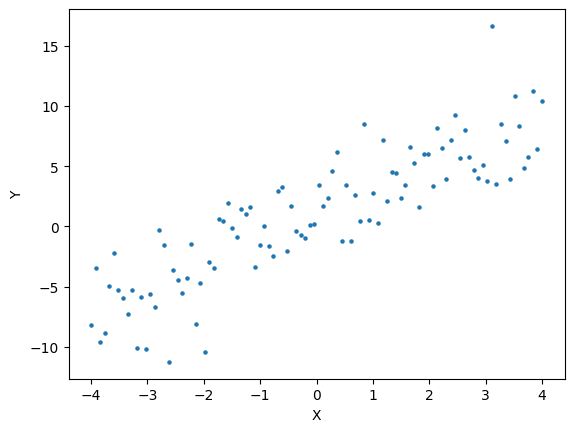

In [11]:
# parameter values, theta = (b0,b1,sigma)
b0    = 0.5
b1    = 2
sigma = 3

x = np.linspace(-4,4,100)
y = np.random.normal( b0 + b1*x, sigma)

plt.scatter(x,y,s=5)
plt.xlabel("X")
plt.ylabel("Y")

#--easy way to build a dataset in pandas
import pandas as pd 
d = pd.DataFrame({"x":x, "y":y})
print(d.head())

## Modeling Fitting 
(Parametric) model fitting is deciding, assuming our model is the true process that generated our data, which parameter values are most likely to have generated the observations that we have collected.

## Least squares
Suppose you are interested in values for a variable $y$ called your response given values of a variable $x$ called your 
A **parametric** model inputs a vector of values, called parameters, and returns a vector of estimated responses.
One way we may evaluate how well the parameter values ($\beta_{0}$, $\beta_{1}$) fits the data is with least squares. 

Given $y_{t} = \beta_{0} + \beta_{1}x_{t}$ and a set of parameter values $(\beta_{0}, \beta_{1})$, we can evaluate how well $(\beta_{0}, \beta_{1})$ fits the data by computing the average squared distance between the real data values $(y_{0},y_{1},\cdots,y_{n})$ and the model-outputted values $(\hat{y}_{0},\hat{y}_{1},\cdots,\hat{y}_{n})$. 

\begin{align}
    SSE(\beta_{0},\beta_{1}) &= \frac{1}{n} \sum_{i=0}^{n} \left( y_{i} - \hat{y_{i}} \right)^{2}\\
    \hat{y_{i}}              &= \beta_{0} + \beta_{1} x_{i}
\end{align}

For example, given $\theta = (0.5,1)$ we can compute 

In [12]:
def SSE(b0,b1,data):
    yhat = b0 + b1*data.x.values
    return np.mean( (yhat - data.y.values)**2 )
SSE(0.5,1,d)

13.546905746143757

If we can evaluate the quality of fit then we can compare two fits.
If we can compare two fits then that means that we can find **the best** fit, the fit that is better than all others. 
The best fit, the one that minimizes (or maximizes depending on the metric that you use to define fit) can be found using several different computational approaches. 

Here is an example of three fits and the associated SSEE



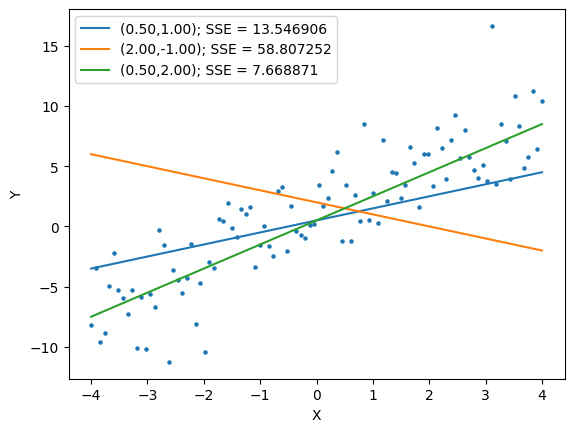

In [13]:
fig,ax = plt.subplots()

ax.scatter(x,y,s=5)

b0 = 0.5
b1 = 1.0

sse = SSE(b0,b1,d)
ax.plot(x, b0+b1*x, label="({:.2f},{:.2f}); SSE = {:f}".format(b0,b1,sse))

b0 = 2.0
b1 = -1.0

sse = SSE(b0,b1,d)
ax.plot(x, b0+b1*x, label="({:.2f},{:.2f}); SSE = {:f}".format(b0,b1,sse))

b0 = 0.5
b1 = 2.0

sse = SSE(b0,b1,d)
ax.plot(x, b0+b1*x, label="({:.2f},{:.2f}); SSE = {:f}".format(b0,b1,sse))

plt.xlabel("X")
plt.ylabel("Y")

plt.legend()

We can find the best fit using the scipy function called minimize.
What you need for the minimize function is
1. An objective function that inputs parameters and outputs a value that describes the fit. Smaller values indiciate better fit.
2. An initial guess at the nesy parameter values. 

The minimize function returns the best parameter values (possibly). 

In [14]:
from scipy.optimize import minimize 
def SSE(params,data):
    b0,b1 = params                              #--"Unroll" parameters from the variable params
    yhat = b0 + b1*data.x.values                #--Build our model of the expected y
    return np.mean( (yhat - data.y.values)**2 ) #--Compute the SSE

results = minimize( lambda x: SSE(x,data=d), x0=np.array([1,1])  )
print(results)

      fun: 7.4447446622552045
 hess_inv: array([[0.50997546, 0.00107961],
       [0.00107961, 0.09200906]])
      jac: array([1.13248825e-06, 6.55651093e-07])
  message: 'Optimization terminated successfully.'
     nfev: 21
      nit: 6
     njev: 7
   status: 0
  success: True
        x: array([0.96406295, 2.04015359])



**Lets study the four lines inside our function SSE in depth.**

1. `def SSE(params,data):`
    1. This defines a function that takes two inputs: `params` and `data`.Inside the function, `params` will be accessible to us as a list of two values, our b0 and b1.Inside the function, `data` will be accessible to us as a data frame of x and y values.
2. `b0,b1 = params`
    1. The first value in `params` is assigned to the variable `b0` and the second value in params is assigned to the variable `b1`.
3. `yhat = b0 + b1*data.x.values`
    1. Compute the expcted value for each `x` value in our dataset.
For linear regression, the expected value is $\beta_{0} + \beta_{1}x$.
4. `return np.mean( (yhat - data.y.values)**2 )`
    1. This computes the SSE and then returns that value outside the function. 

The  `results = minimize( lambda x: SSE(x,data=d), x0=np.array([1,1])  )` returns an object that is stored in the variable `results`. The optimal parameter values are stored in results under the attribute "x".
Lets plot the expected value that is "optimal".

We can plot our results to evaluate how well the optimized function matches our intuition. 

[0.96406295 2.04015359]


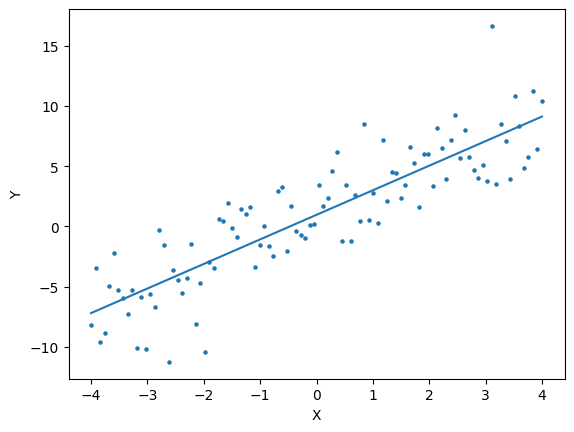

In [15]:
fig,ax = plt.subplots()

ax.scatter(x,y,s=5)

print(results.x)
b0,b1 = results.x
ax.plot(x, b0+b1*x, label="({:.2f},{:.2f}); SSE = {:f}".format(b0,b1,sse))

plt.xlabel("X")
plt.ylabel("Y")

plt.show()

### Least squares for compartmental models 
We can apply the same procedure for linear regression to compartmental models.

In [16]:
#--BUILD OUR DATASET
n = 1000 #--number of animals in system 

#--SIR differential equations
def sir(t,y, beta, gamma,n):
    s,i, r, c = y
    ds_dt = -beta*s*i/n
    di_dt = beta*s*i/n - gamma*i
    dr_dt = gamma*i
    
    dc_dt = beta*s*i/n            #--incident cases (why?)
    return [ds_dt, di_dt, dr_dt, dc_dt]

#--start and end times 
start,end = 0., 20

#--times that we want to return s(t), i(t), r(t)
tvals = np.arange(start,end+0.1,0.1)

#--inital conditions for s, i, r
initial_conditions = (999, 1, 0., 0)

#--parameters for the model 
beta, gamma = 3./2, 1./3

#--function to return s,i,r over time
solution = solve_ivp( fun = sir
                     , t_span = (start,end)
                     , y0     = initial_conditions
                     , t_eval = tvals
                     , args   = (beta, gamma,n))
prevalent_infections = solution.y[1,:]
times                = solution.t 

random_noise = np.random.poisson(prevalent_infections)

data = pd.DataFrame({"times":times, "infections":random_noise})

from scipy.optimize import minimize 
def SSE(params,data,n):                         #--lets assume n is fixed 
    beta,gamma = params                         #--"Unroll" parameters from the variable params
    #--Build our SIR model of the expected y
    
    #--SIR differential equations
    def sir(t,y, beta, gamma,n):
        s,i, r, c = y
        ds_dt = -beta*s*i/n
        di_dt = beta*s*i/n - gamma*i
        dr_dt = gamma*i
        
        dc_dt = beta*s*i/n            #--incident cases (why?)
        return [ds_dt, di_dt, dr_dt, dc_dt]
        
    #--inital conditions for s, i, r      Assume fixed for now
    initial_conditions = (999, 1, 0., 0)

    start = min(data.times)
    end   = max(data.times) 
    
    solution = solve_ivp( fun = sir
                     , t_span = (start,end)
                     , y0     = initial_conditions
                     , t_eval = data.times.values  #<--evaluate our solution at all the x values we have in the data
                     , args   = (beta, gamma,n))
    prevalent_infections = solution.y[1,:]
    times                = solution.t 

    return np.mean( (prevalent_infections - data.infections.values)**2 ) #--Compute the SSE

results = minimize( lambda x: SSE(x,data=data,n=1000), x0=np.array([2,1])  )
print(results)

      fun: 145.77724377363504
 hess_inv: array([[1.53106218e-06, 2.20281946e-06],
       [2.20281946e-06, 3.18487922e-06]])
      jac: array([0.00135231, 0.00079155])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 283
      nit: 14
     njev: 89
   status: 2
  success: False
        x: array([1.49697036, 0.33155707])


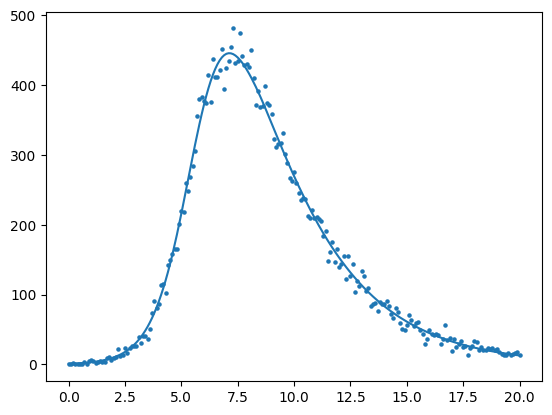

In [17]:
beta,gamma = results.x
#--inital conditions for s, i, r      Assume fixed for now
initial_conditions = (999, 1, 0., 0)

start = min(data.times)
end   = max(data.times) 

solution = solve_ivp( fun = sir
                 , t_span = (start,end)
                 , y0     = initial_conditions
                 , t_eval = data.times.values  #<--evaluate our solution at all the x values we have in the data
                 , args   = (beta, gamma,n))
prevalent_infections = solution.y[1,:]
times                = solution.t 

plt.scatter(data.times.values,data.infections.values,s=5)
plt.plot(times,prevalent_infections)

## Least squares is just a special type of maximum likelihood estimation

Lets look at a typical, first example of maximum likelihood estimation and see that least squares is a special case.
Suppose you want to model a dataset $\mathcal{D} = (y_{1}, y_{2},y_{3},\cdots,y_{n})$ with the following model

\begin{align}
    y_{i} &\sim Y_{i} \\ 
    Y_{i} &\sim \mathcal{N}(\mu,\sigma^{2})
\end{align}

that is, we will assume each data point was drawn from a Normal distribution with mean $\mu$ and variance $\sigma^{2}$. Lets go a step further and assume that we know the variance $\sigma^{2} = 1$. 

Our goal is to estimate $\mu$. 
One way to develop an objective function that we can use to compare two $\mu$ values is maximum likelihood estimation (MLE). 
MLE says that a $\mu$ value is high quality if there is a high probability that this parameter value was used to generate our dataset. 
The probability of our dataset given a specific, single $\mu$ value is 

\begin{align}
    &p( \mathcal{D} | \mu, \sigma^{2} = 1 ) \\ 
    &p( [y_{1}, y_{2},y_{3},\cdots,y_{n}] | \mu, \sigma^{2} = 1 ) \\ 
\end{align}    

well this is sort of a problem. 
We dont know the joint probability of each of the values in our data simulataneously.
Instead, lets assume that all the observations were generated **independently** from one another. 
Then the above simplifies to 

\begin{align}
    &p( [y_{1}, y_{2},y_{3},\cdots,y_{n}] | \mu, \sigma^{2} = 1 ) \\ 
    &p( [y_{1}  | \mu, \sigma^{2} = 1 ) \times  p(y_{2} | \mu, \sigma^{2} = 1 ) \times p(y_{3} | \mu, \sigma^{2} = 1 )\cdots \times p(y_{n} | \mu, \sigma^{2} = 1 )] | \mu, \sigma^{2} = 1 ) \\ 
\end{align}    

This is called the **likelihood function**. 
The input is a set of parameters (in this case $\mu$) and the output is the probability that this parameter value helped generated the dataset. 

Lets substitute p(y|\mu,\sigma^{2}) for the functional form of the Normal distribution and simplify. 
The Normal distribution has probability density
\begin{align}
    p(y|\mu,\sigma^{2}) = \frac{1}{\sqrt{2\pi\sigma^{2}}} \exp \left\{ \frac{1}{2}\left[ \frac{y-\mu}{\sigma} \right]^{2} \right\}
\end{align}

If we can compute the probability of a dataset with two y values, then maybe we can find a pattern that we can apply to a dataset with $n$ values. 

\begin{align}
    p(y_{1}|\mu,\sigma^{2}) \cdot p(y_{2}|\mu,\sigma^{2}) =  \\
     \frac{1}{\sqrt{2\pi\sigma^{2}}} \exp \left\{ -\frac{1}{2}\left[ \frac{y_{1}-\mu}{\sigma} \right]^{2} \right\} \cdot \frac{1}{\sqrt{2\pi\sigma^{2}}} \exp \left\{ -\frac{1}{2}\left[ \frac{y_{2}-\mu}{\sigma} \right]^{2} \right\}\\
      \left(\frac{1}{\sqrt{2\pi\sigma^{2}}}\right)^{2} \cdot \exp \left\{ -\frac{1}{2} \left[\frac{y_{1}-\mu}{\sigma}\right]^{2} +  \left[\frac{y_{2}-\mu}{\sigma} \right]^{2} \right\} \\ 
      \left(\frac{1}{\sqrt{2\pi\sigma^{2}}}\right)^{2} \cdot \exp \left\{ -\frac{1}{2\sigma^{2}} \left[y_{1}-\mu\right]^{2} +  \left[y_{2}-\mu \right]^{2} \right\} \\ 
\end{align}

Looks like a pattern is forming. 
For $n$ data points

\begin{align}
      \left(\frac{1}{\sqrt{2\pi\sigma^{2}}}\right)^{n} \cdot \exp \left\{ -\sum_{i=1}^{n} \frac{1}{2\sigma^{2}} \left[y_{i}-\mu\right]^{2}  \right\} \\ 
\end{align}

How the heck do we maximize this???
Recall that $e^{-x^{2}}$ is a bell curve peaked at zero.
Therefore, the function $e^{-x^{2}}$ is maximized when $x=0$, and so it follows that the function 
$e^{-(x-a)^{2}}$ is maximized when $x=a$. 
In other words, maximizing the function $e^{-(x-a)^{2}}$ is the same as minimizing the function $(x-a)^{2}$ (think about this for a minute, its not immediately intuitive.). 

Lets apply this idea to our problem above.
Maximizing the function $\exp \left\{ -\sum_{i=1}^{n} \frac{1}{2\sigma^{2}} \left[y_{i}-\mu\right]^{2}\right\}$ is the same as minimizing the function 
$\sum_{i=1}^{n} \frac{1}{2\sigma^{2}} \left[y_{i}-\mu\right]^{2}$.
If we set $\sigma^{2}=1$ then our goal is to minimize

\begin{align}
    \sum_{i=1}^{n} \left[y_{i}-\mu\right]^{2} \propto  \frac{1}{n}\sum_{i=1}^{n} \left[y_{i}-\mu\right]^{2} = \text{SSE} 
\end{align}

### What does this mean, though?

This means that when we were minimizing the SSE we (implictly) assumed that our data was generated by a Normal distribution---whoa. 

## Homework 
1. We will fit our model assuming Binomial noise
   1. Given data points $(y_{1},y_{2},y_{3}, \cdots, y_{t})$ write down the likelihood given a parameter value $\theta$ and number of samples $N$. In other words, write down the likelihood for the following model
   \begin{align}
        \mathcal{D} = (y_{1},y_{2}, \cdots, y_{t})\\
         Y_{i} \sim \text{Bin}(y_{i} | N,\theta)
    \end{align}
2. Compute the loglikelihood by taking the log of your answer for (1).
3. Compute the negative loglikelihood by multiplying by -1 (this one is easy)
4. Code the negative loglikelihood into a function called `nll_binom`.
   1. This function takes as input a list `y` that represents the observed data and a list `I` that represents the proportion of prevalent infections. The proportion of prevalent infections will serve as our $\theta$ for the negative loglikelihood.
   2. The output is the negative loglikelihood
5. Use the scipy `minimize` function to compute a SIR and return the negative loglikelihood.
   1. You will need to create a function called `objective function` that takes as input a list of parameters called `params` and a dataset called `data` (dataset is below).
   2. The output of the objective function is the negative loglikelihood
6. Please print the parameter values and plot a fitted number of infections.

### Dataset

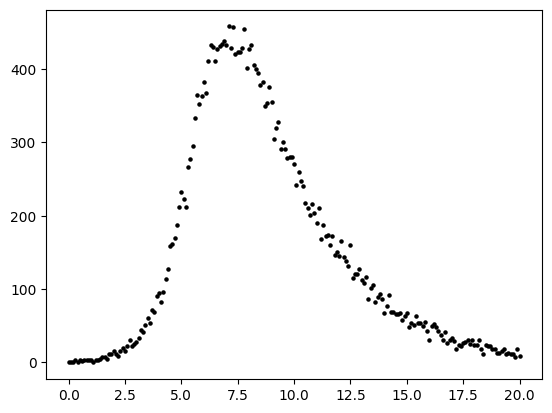

In [32]:
beta, gamma = 3./2, 1./3

#--SIR differential equations
def sir(t,y, beta, gamma):
    s,i, r, c = y
    ds_dt = -beta*s*i
    di_dt = beta*s*i - gamma*i
    dr_dt = gamma*i
    
    dc_dt = beta*s*i            #--incident cases (why?)
    return [ds_dt, di_dt, dr_dt, dc_dt]
    
#--inital conditions for s, i, r      Assume fixed for now
initial_conditions = (999./1000, 1./1000, 0., 0)

solution = solve_ivp( fun = sir
                 , t_span = (start,end)
                 , y0     = initial_conditions
                 , t_eval = data.times.values  #<--evaluate our solution at all the x values we have in the data
                 , args   = (beta, gamma))
prop_prevalent_infections = solution.y[1,:]
times                = solution.t 

y_values = np.random.binomial(1000, prop_prevalent_infections)


data = pd.DataFrame({"times":times, "y":y_values})

plt.scatter(data.times, data.y, color='k', s=5)

In [40]:
from scipy.optimize import minimize 
def nll(params, data):
    beta,gamma = params
    
    from scipy.stats import poisson
    import numpy as np

    def sir(t,y, beta, gamma):
        s,i, r, c = y
        ds_dt = -beta*s*i
        di_dt = beta*s*i - gamma*i
        dr_dt = gamma*i
        
        dc_dt = beta*s*i            #--incident cases (why?)
        return [ds_dt, di_dt, dr_dt, dc_dt]

    N = 1000
    initial_conditions = (999./1000, 1./1000, 0., 0)
    
    start = min(data.times)
    end   = max(data.times) 

    solution = solve_ivp( fun = sir
                 , t_span = (start,end)
                 , y0     = initial_conditions
                 , t_eval = data.times.values  #<--evaluate our solution at all the x values we have in the data
                 , args   = (beta, gamma))
    prop_prevalent_infections = solution.y[1,:]
    expected = N*prop_prevalent_infections
    
    return -1*np.sum(poisson(expected).logpmf(data.y.values))

import numpy as np
beta,gamma = 1.,1./2
results = minimize( lambda params: nll(params,data), x0  = np.array([beta,gamma]) )
print(results)

      fun: 686.2162518167438
 hess_inv: array([[1.65629345e-06, 3.78798134e-07],
       [3.78798134e-07, 4.35711206e-06]])
      jac: array([8.39233398e-05, 2.28881836e-04])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 173
      nit: 13
     njev: 54
   status: 2
  success: False
        x: array([1.50367359, 0.33412108])


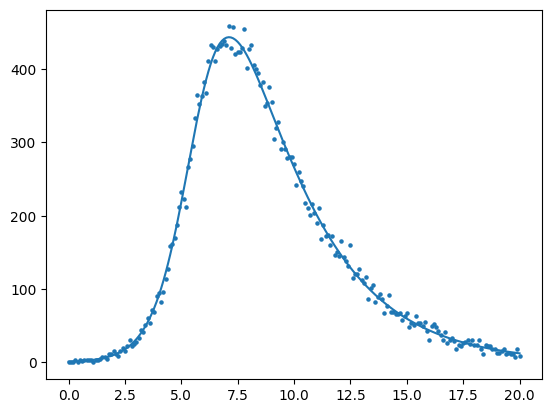

In [41]:
beta,gamma = results.x

def sir(t,y, beta, gamma):
    s,i, r, c = y
    ds_dt = -beta*s*i
    di_dt = beta*s*i - gamma*i
    dr_dt = gamma*i
    
    dc_dt = beta*s*i            #--incident cases (why?)
    return [ds_dt, di_dt, dr_dt, dc_dt]

N = 1000
initial_conditions = (999./1000, 1./1000, 0., 0)

start = min(data.times)
end   = max(data.times) 

solution = solve_ivp( fun = sir
             , t_span = (start,end)
             , y0     = initial_conditions
             , t_eval = data.times.values  #<--evaluate our solution at all the x values we have in the data
             , args   = (beta, gamma))
prop_prevalent_infections = solution.y[1,:]
expected = N*prop_prevalent_infections

plt.scatter(data.times.values, data.y.values, s=5)
plt.plot(data.times.values,expected)


22644.77809155103